In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as linalg
import os
import time
from lib.ParticleFilter import sample_normal_model, single_step_particle_filter, normal_model_pdf, single_step_particle_filter_measurement_window
from utils.plotting import draw_ellipse, images_to_gif

In [21]:
def get_exp_folder(note=''):
    if not os.path.exists('results'):
        os.makedirs('results')

    date = time.strftime("%Y%m%d")
    if not os.path.exists(os.path.join('results', date)):
        os.makedirs(f'results/{date}')
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    exp_folder_name = path = os.path.join('results', date, f'exp_{timestamp}')
    
    if note != '':
        exp_folder_name += f'_{note}'
    os.mkdir(exp_folder_name)
    frames_folder = os.path.join(exp_folder_name, 'frames')
    os.mkdir(frames_folder)
    return exp_folder_name, frames_folder

In [22]:

## setup params
NUM_OF_BEACONS = 4
NUM_OF_AGENTS = 1
STATE_SIZE_2D = 2
SINGLE_RANGE_MEASUREMENT_SIZE = 1
RANGE_MEASUREMENT_SIZE = NUM_OF_BEACONS * SINGLE_RANGE_MEASUREMENT_SIZE * NUM_OF_AGENTS
# AGENTS_INDEX = [i for i in range(STATE_SIZE_2D*NUM_OF_AGENTS)]
# BEACONS_INDEX = [AGENTS_INDEX[-1] + 1 +  i for i in range(STATE_SIZE_2D*NUM_OF_BEACONS)]
TOTAL_STATE_SIZE = NUM_OF_AGENTS * STATE_SIZE_2D + NUM_OF_BEACONS * STATE_SIZE_2D
NOTE = 'single_beacon'
get_agent_index = lambda i: slice(i*STATE_SIZE_2D, i*STATE_SIZE_2D + STATE_SIZE_2D)
get_beacon_index = lambda i: slice(STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D, STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D + STATE_SIZE_2D)
get_agent_position = lambda x, i: x[get_agent_index(i)]
get_beacon_postion = lambda x, j: x[get_beacon_index(j)]
sigma_transition_agent = 0.5
sigma_transition_beacon = 0.3
sigma_measurement = 0.1
stepsize = 2
n_steps = 150
n_particles = 100
# model definition
cov_measurement = np.diag([sigma_measurement**2 for i in range(RANGE_MEASUREMENT_SIZE)])
cov_transition_agent = [sigma_transition_agent**2 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_agent = [0 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_beacon = [sigma_transition_beacon**2 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon = [0 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon[0:6] = [sigma_transition_beacon**2]*6
cov_transition = np.diag(cov_transition_agent + cov_transition_beacon)

propagate_state = lambda x, u: x + sample_normal_model(u, cov_transition)

def calculate_true_range_meas(x):
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):
        current_agent_position = x[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            current_beacon_position = x[get_beacon_index(j)]
            z[i*NUM_OF_BEACONS + j] = np.linalg.norm(current_agent_position - current_beacon_position)
    return z

def measurements_model(x, cov = cov_measurement):
    return calculate_true_range_meas(x) + sample_normal_model(np.zeros(RANGE_MEASUREMENT_SIZE), cov)

measurements_likelihood = lambda z, x: normal_model_pdf(z, calculate_true_range_meas(x), cov_measurement)


In [23]:
## test models  
if 0:
    x = np.array([0, 0, 1, 0, 2, 0, 3, 0, 4, 0])*100
    u = np.zeros(TOTAL_STATE_SIZE)
    print(measurements_model(x))
    print(propagate_state(x, u))

In [24]:
def state_to_agent_and_beacons_pos(x):
    agents_pos = np.zeros((NUM_OF_AGENTS, STATE_SIZE_2D))
    beacons_pos = np.zeros((NUM_OF_BEACONS, STATE_SIZE_2D))
    for i in range(NUM_OF_AGENTS):
        agents_pos[i] = get_agent_position(x, i)
    for j in range(NUM_OF_BEACONS):
        beacons_pos[j] = get_beacon_postion(x, j)
    return agents_pos, beacons_pos
def agent_and_beacons_pos_to_state(agents_pos, beacons_pos):
    x = np.zeros(TOTAL_STATE_SIZE)
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] = agents_pos[i]
    for j in range(NUM_OF_BEACONS):
        x[get_beacon_index(j)] = beacons_pos[j]
    return x

In [25]:
## test conversion functions
if 0:
    x = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])
    agents_pos, beacons_pos = state_to_agent_and_beacons_pos(x)
    print(agents_pos, beacons_pos)
    print(agent_and_beacons_pos_to_state(agents_pos, beacons_pos))

In [26]:
## generate ground truth
agent_position_0 = np.array([0,0])
becons_1_position_0 = np.array([10,10])
becons_2_position_0 = np.array([-10,10])
becons_3_position_0 = np.array([10,-10])
becons_4_position_0 = np.array([-10,-10])
x_0 = agent_and_beacons_pos_to_state([agent_position_0], [becons_1_position_0, becons_2_position_0, becons_3_position_0, becons_4_position_0])

#genrate u  commend vector
u = (np.random.rand(TOTAL_STATE_SIZE, n_steps) - 0.5) * stepsize
u = np.zeros((TOTAL_STATE_SIZE, n_steps))
u[get_agent_index(0),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize
u[get_beacon_index(0),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(1),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(2),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(3),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
## create ground truth
x = np.zeros((TOTAL_STATE_SIZE, n_steps))
x[:,0] = x_0
z = np.zeros((RANGE_MEASUREMENT_SIZE, n_steps))
z[:,0] = measurements_model(x[:,0])
for i in range(1, n_steps):
    x[:,i] = propagate_state(x[:,i-1], u[:,i-1])
    z[:,i] = measurements_model(x[:,i])

## plot ground truth
if 0:
    fig, ax = plt.subplots()
    ax.plot(x[0,:], x[1,:], 'r')
    ax.plot(x[2,:], x[3,:], 'g')
    ax.plot(x[4,:], x[5,:], 'b')
    ax.plot(x[6,:], x[7,:], 'y')
    ax.plot(x[8,:], x[9,:], 'm')
    plt.show()


In [28]:
def draw_frame(x,particles,frames_folder,i,elipse = True):
    colors = ['r', 'g', 'b', 'y', 'm']
    fig, ax = plt.subplots()
    for j in range(NUM_OF_AGENTS):
        agent_gt_pos = x[get_agent_index(j),i]
        agent_particles = particles[:,get_agent_index(j)]
        agent_color = colors[j]
        ax.scatter(agent_gt_pos[0], agent_gt_pos[1], color = agent_color)
        if elipse:
            draw_ellipse(ax, edgecolor = agent_color ,data = agent_particles)
        else:
            ax.scatter(agent_particles[:,0], agent_particles[:,1], c = agent_color, marker = 'x')
            
    for j in range(NUM_OF_BEACONS):
        beacon_gt_pos = x[get_beacon_index(j),i]
        beacon_particles = particles[:,get_beacon_index(j)]
        beacon_color = colors[j+NUM_OF_AGENTS]
        ax.scatter(beacon_gt_pos[0], beacon_gt_pos[1], color = beacon_color)
        if elipse:
            draw_ellipse(ax, edgecolor= beacon_color ,data = beacon_particles)
        else:
            ax.scatter(beacon_particles[:,0], beacon_particles[:,1], c = beacon_color, marker = 'x')
    
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    plt.title(f'frame {i}')
    plt.savefig(f'{frames_folder}/frame_{i}.png')
    plt.close()
    
def calculate_mean_and_cov(particles):
    mean = np.mean(particles, axis = 0)
    cov = np.cov(particles.T).flatten()
    return mean, cov

def save_ground_truth(x, z, exp_folder):
    pd.DataFrame(x).to_csv(f'{exp_folder}/ground_truth_state.csv')
    pd.DataFrame(z).to_csv(f'{exp_folder}/ground_truth_measurement.csv')

def save_current_particles(particles, exp_folder, i):
    if not os.path.exists(exp_folder):
        os.makedirs(exp_folder)
    if not os.path.exists(f'{exp_folder}/particles'):
        os.makedirs(f'{exp_folder}/particles')
    pd.DataFrame(particles).to_csv(f'{exp_folder}/particles/particles_{i}.csv')


In [44]:
## particle filter
NOTE = 'deterministic agent'
exp_folder, frames_folder = get_exp_folder(note = NOTE)
mean_log = np.zeros((n_steps,TOTAL_STATE_SIZE))
cov_log = np.zeros((n_steps,TOTAL_STATE_SIZE**2))
n_particles = 1000
particles = (np.random.rand(n_particles, TOTAL_STATE_SIZE) - 0.5) * 15
particles[:,get_agent_index(0)] = np.zeros((n_particles, STATE_SIZE_2D))
particles[:,get_beacon_index(0)] = particles[:,get_beacon_index(0)] + becons_1_position_0
particles[:,get_beacon_index(1)] = particles[:,get_beacon_index(1)] + becons_2_position_0
particles[:,get_beacon_index(2)] = particles[:,get_beacon_index(2)] + becons_3_position_0
particles[:,get_beacon_index(3)] = particles[:,get_beacon_index(3)] + becons_4_position_0
#particles[:,get_beacon_index(2)] = np.zeros((n_particles, STATE_SIZE_2D)) + becons_3_position_0
#particles[:,get_beacon_index(3)] = np.zeros((n_particles, STATE_SIZE_2D)) + becons_4_position_0
for i in range(n_steps):
    if 1:
        draw_frame(x,particles,frames_folder,i,elipse = False)
    save_current_particles(particles, exp_folder, i)
    particles = single_step_particle_filter(particles, u[:,i], z[:,i], propagate_state, measurements_likelihood)
    mean_log[i], cov_log[i] = calculate_mean_and_cov(particles)
    print(f"\r{i}/{n_steps}", end='', flush=True)
print('\n')
if 1:
    draw_frame(x, particles,frames_folder,i = n_steps - 1, elipse = False)
    save_current_particles(particles, exp_folder, n_steps)
images_to_gif(frames_folder, f'{exp_folder}/particle_filter.gif')
pd.DataFrame(mean_log).to_csv(f'{exp_folder}/mean_log.csv', index = False, header = False)
pd.DataFrame(cov_log).to_csv(f'{exp_folder}/cov_log.csv', index = False, header = False)
save_ground_truth(x, z, exp_folder)


149/150

gif saved to results\20240516\exp_20240516_162848_deterministic agent/particle_filter.gif


In [34]:
## particle filter
NOTE = 'deterministic agent - with circle intilization'
exp_folder, frames_folder = get_exp_folder(note = NOTE)
mean_log = np.zeros((n_steps,TOTAL_STATE_SIZE))
cov_log = np.zeros((n_steps,TOTAL_STATE_SIZE**2))
n_particles = 1000
particles = (np.random.rand(n_particles, TOTAL_STATE_SIZE) - 0.5) * 15
particles[:,get_agent_index(0)] = np.zeros((n_particles, STATE_SIZE_2D))
r = np.linalg.norm(becons_1_position_0)
theta = np.linspace(0, 2*np.pi, n_particles)
beacons_pos_0 = np.array([r*np.cos(theta), r*np.sin(theta)]).T
particles[:,get_beacon_index(0)] = beacons_pos_0
particles[:,get_beacon_index(1)] = beacons_pos_0
particles[:,get_beacon_index(2)] = beacons_pos_0
particles[:,get_beacon_index(3)] = beacons_pos_0
# particles[:,get_beacon_index(0)] = particles[:,get_beacon_index(0)] + becons_1_position_0
# particles[:,get_beacon_index(1)] = particles[:,get_beacon_index(1)] + becons_2_position_0
# particles[:,get_beacon_index(2)] = particles[:,get_beacon_index(2)] + becons_3_position_0
# particles[:,get_beacon_index(3)] = particles[:,get_beacon_index(3)] + becons_4_position_0
#particles[:,get_beacon_index(2)] = np.zeros((n_particles, STATE_SIZE_2D)) + becons_3_position_0
#particles[:,get_beacon_index(3)] = np.zeros((n_particles, STATE_SIZE_2D)) + becons_4_position_0
for i in range(n_steps):
    if 1:
        draw_frame(x,particles,frames_folder,i,elipse = False)
    save_current_particles(particles, exp_folder, i)
    particles = single_step_particle_filter(particles, u[:,i], z[:,i], propagate_state, measurements_likelihood)
    mean_log[i], cov_log[i] = calculate_mean_and_cov(particles)
    print(f"\r{i}/{n_steps}", end='', flush=True)
print('\n')
if 1:
    draw_frame(x, particles,frames_folder,i = n_steps - 1, elipse = False)
    save_current_particles(particles, exp_folder, n_steps)
images_to_gif(frames_folder, f'{exp_folder}/particle_filter.gif')
pd.DataFrame(mean_log).to_csv(f'{exp_folder}/mean_log.csv', index = False, header = False)
pd.DataFrame(cov_log).to_csv(f'{exp_folder}/cov_log.csv', index = False, header = False)
save_ground_truth(x, z, exp_folder)


149/150

gif saved to results\20240516\exp_20240516_145537_deterministic agent - with circle intilization/particle_filter.gif


In [ ]:
## particle filter
mean_log = np.zeros((n_steps,TOTAL_STATE_SIZE))
cov_log = np.zeros((n_steps,TOTAL_STATE_SIZE**2))
n_particles = 1000
particles = (np.random.rand(n_particles, TOTAL_STATE_SIZE) - 0.5) * 15
particles[:,get_beacon_index(0)] = particles[:,get_beacon_index(0)] + becons_1_position_0
particles[:,get_beacon_index(1)] = particles[:,get_beacon_index(1)] + becons_2_position_0
particles[:,get_beacon_index(2)] = particles[:,get_beacon_index(2)] + becons_3_position_0
particles[:,get_beacon_index(3)] = particles[:,get_beacon_index(3)] + becons_4_position_0
#particles[:,get_beacon_index(2)] = np.zeros((n_particles, STATE_SIZE_2D)) + becons_3_position_0
#particles[:,get_beacon_index(3)] = np.zeros((n_particles, STATE_SIZE_2D)) + becons_4_position_0
for i in range(n_steps):
    if 1:
        draw_frame(x,particles,frames_folder,i,elipse = True)
    save_current_particles(particles, f'{exp_folder}/particles', i)
    particles = single_step_particle_filter(particles, u[:,i], z[:,i], propagate_state, measurements_likelihood)
    mean_log[i], cov_log[i] = calculate_mean_and_cov(particles)
    print(f"\r{i}/{n_steps}", end='', flush=True)
print('\n')
if 1:
    draw_frame(x, particles,frames_folder,i = n_steps - 1, elipse = True)
    save_current_particles(particles, f'{exp_folder}/particles', n_steps)
images_to_gif(frames_folder, f'{exp_folder}/particle_filter.gif')
pd.DataFrame(mean_log).to_csv(f'{exp_folder}/mean_log.csv', index = False, header = False)
pd.DataFrame(cov_log).to_csv(f'{exp_folder}/cov_log.csv', index = False, header = False)
save_ground_truth(x, z, exp_folder)

In [ ]:
NOTE = 'window_size_4'
exp_folder, frames_folder = get_exp_folder(note = NOTE)
mean_log = np.zeros((n_steps,TOTAL_STATE_SIZE))
cov_log = np.zeros((n_steps,TOTAL_STATE_SIZE**2))
n_particles = 1000
particles = (np.random.rand(n_particles, TOTAL_STATE_SIZE) - 0.5) * 15
particles[:,get_beacon_index(0)] = particles[:,get_beacon_index(0)] + becons_1_position_0
particles[:,get_beacon_index(1)] = particles[:,get_beacon_index(1)] + becons_2_position_0
particles[:,get_beacon_index(2)] = particles[:,get_beacon_index(1)] + becons_2_position_0
particles[:,get_beacon_index(3)] = particles[:,get_beacon_index(1)] + becons_2_position_0
# particles[:,get_beacon_index(2)] = np.zeros((n_particles, STATE_SIZE_2D)) + becons_3_position_0
# particles[:,get_beacon_index(3)] = np.zeros((n_particles, STATE_SIZE_2D)) + becons_4_position_0
weights = np.ones(n_particles) / n_particles
for i in range(n_steps):
    if 1:
        draw_frame(x,particles,frames_folder,i,elipse = True)
    particles, weights = single_step_particle_filter_measurement_window(particles, u[:,i], z[:,i], propagate_state, measurements_likelihood,i,weights=weights, window_size = 1)
    mean_log[i], cov_log[i] = calculate_mean_and_cov(particles)
    print(f"\r{i}/{n_steps}", end='', flush=True)
print('\n')
if 1:
    draw_frame(x, particles,frames_folder,i = n_steps - 1, elipse = True)
images_to_gif(frames_folder, f'{exp_folder}/particle_filter.gif')
pd.DataFrame(mean_log).to_csv(f'{exp_folder}/mean_log.csv', index = False, header = False)
pd.DataFrame(cov_log).to_csv(f'{exp_folder}/cov_log.csv', index = False, header = False)

In [ ]:
def calculate_linear_measurement_matrix(agent, beacon):
    range = np.linalg.norm(agent - beacon)
    H = np.zeros((1, 2*STATE_SIZE_2D))
    H[0,0] = (agent[0] - beacon[0])/range
    H[0,1] = (agent[1] - beacon[1])/range 
    H[0,2] = (beacon[0] - agent[0])/range
    H[0,3] = (beacon[1] - agent[1])/range
    return H

def total_linear_measurement_matrix(x):
    H = np.zeros((RANGE_MEASUREMENT_SIZE, TOTAL_STATE_SIZE))
    for i in range(NUM_OF_AGENTS):
        agent_position = get_agent_position(x, i)
        for j in range(NUM_OF_BEACONS):
            beacon_position = get_beacon_postion(x, j)
            h = calculate_linear_measurement_matrix(agent_position, beacon_position)
            H[i*NUM_OF_BEACONS + j, get_agent_index(i)] = h[0,0:2]
            H[i*NUM_OF_BEACONS + j, get_beacon_index(j)] = h[0,2:4]
    return H

def calculate_observability_matrix(A,H):
    n = A.shape[0]
    m = H.shape[0]
    O = np.zeros((n*m, n))  
    O[0:m,0:n] = H
    for i in range(1,n):
        O[i*m:(i+1)*m,0:n] = O[(i-1)*m:i*m,0:n]@A
    rank = np.linalg.matrix_rank(O)
    return O, rank
if 1:
    # total_linear_measurement_matrix using ground truth
    H = total_linear_measurement_matrix(x[:,0])
    # print(H)

    # observability matrix using ground truth
    A = np.eye(TOTAL_STATE_SIZE)
    O, rank = calculate_observability_matrix(A,H)
    print(rank)
    print(O.shape)




In [ ]:
# plot observability matrix rank over time:
if 1:
    rank_log = np.zeros(n_steps)
    for i in range(n_steps):
        H = total_linear_measurement_matrix(x[:,0])
        O, rank = calculate_observability_matrix(A,H)
        
        rank_log[i] = rank
    # print(O)
    # calculate the eigenvalues of the observability matrix to find witch states are observable
    eigvals, eigvecs = np.linalg.eig(O.T@O)
    # print(eigvals)
    # null space of the observability matrix
    null_space = linalg.null_space(O)
    print(null_space)
    plt.plot(rank_log)
    plt.xlabel('step')
    
    plt.ylabel('rank')
    plt.show()

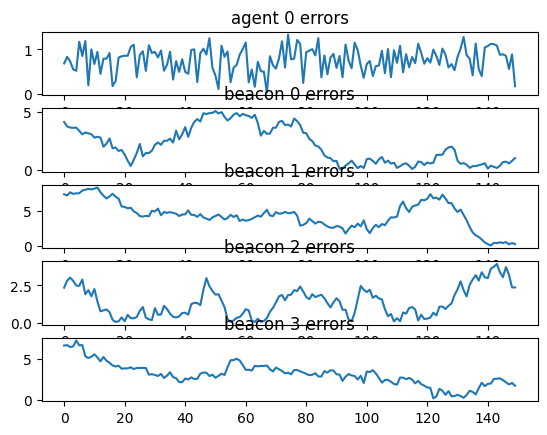

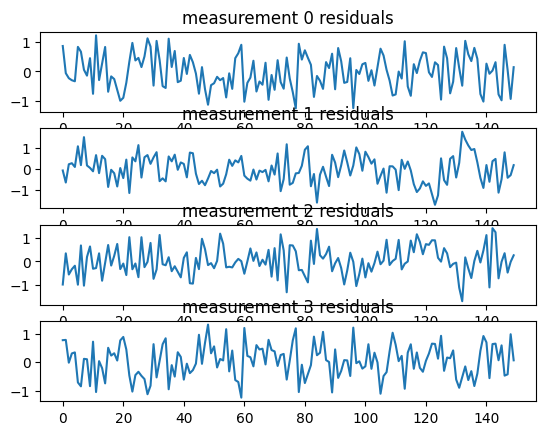

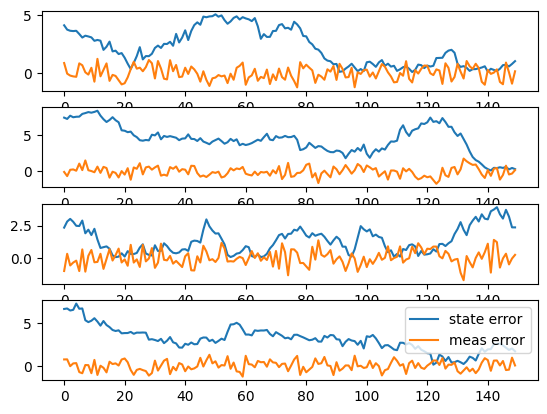

In [57]:
#calc errors
errors = np.zeros((n_steps, TOTAL_STATE_SIZE))
for i in range(n_steps):
    errors[i] = x[:,i] - mean_log[i]
pd.DataFrame(errors).to_csv(f'{exp_folder}/errors.csv', index = False, header = False)

#plot errors, split by aagent and beacons in different subplots for each agent and beacon
if 1:
    fig, axs = plt.subplots(NUM_OF_AGENTS + NUM_OF_BEACONS, 1)
    for i in range(NUM_OF_AGENTS):
        axs[i].plot(np.linalg.norm(errors[:,get_agent_index(i)],axis = 1))
        axs[i].set_title(f'agent {i} errors')
    for j in range(NUM_OF_BEACONS):
        axs[NUM_OF_AGENTS + j].plot(np.linalg.norm(errors[:,get_beacon_index(j)],axis = 1))
        axs[NUM_OF_AGENTS + j].set_title(f'beacon {j} errors')
    plt.show()
    
# plot the measermnt resedules
meas_residual = np.zeros((n_steps, RANGE_MEASUREMENT_SIZE))
for i in range(n_steps):
    meas_residual[i] = calculate_true_range_meas(mean_log[i]) - calculate_true_range_meas(x[:,i])
if 1:
    fig, axs = plt.subplots(RANGE_MEASUREMENT_SIZE, 1)
    for i in range(RANGE_MEASUREMENT_SIZE):
        axs[i].plot(meas_residual[:,i])
        axs[i].set_title(f'measurement {i} residuals')
    plt.show()
# put state error and meas error in the same subplots
if 1:
    fig, axs = plt.subplots(NUM_OF_BEACONS, 1)
    for i in range(NUM_OF_BEACONS):
        axs[i].plot(np.linalg.norm(errors[:,get_beacon_index(i)],axis = 1))
        axs[i].plot(meas_residual[:,i])
        # axs[i].set_title(f'state {i} errors')
    plt.legend(['state error', 'meas error'])
    plt.show()

In [51]:

    print(f"step {i} mean measurment residuals: {meas_residual}")

step 0 mean measurment residuals: [[ 0.86046011 -0.08462065 -0.98100775  0.76852212]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.       